# Ransac sift homography
0.	选择两幅部分内容一致，部分内容不同的图像，两者可以有角度/位移等变化。【这个变化完全可以由第一周的内容自己做出来】
1.	对两幅图像分别进行关键点检测，比如用 SIFT. 【大家完全可以尝试别的关键点】
2.	对两幅图像的关键点进行进行匹配并用 RANSAC 去噪，找到单应性关系(knn)
3.	将第二幅图像按照单应性关系进行变换 【即右乘单应性矩阵】
4.	将两幅图像相互对应的点重合，其余点也即进行融合。因旋转造成图像 size 大小不同等， 补 0 即可。


## SIFT: Scale-Invariant Feature Transform
02--02：40：00

1. GenerateScale-space:DoG 生成尺度空间
2. Scale-spaceExtremaDetection 尺度空间极值点检测
3. AccurateKeypointLocalization 精确定位极值点位置
4. Eliminating Edge Responses 消除边缘效应，阈值判断
5. Orientation Assignment 方向指定
6. Keypoint Descriptor 特征描述


### 1. GenerateScale-space:DoG 生成尺度空间

DoG: Difference of Gaussian

GP: Gaussian Pyramid 高斯金字塔
octave，缩小1/2生成octave：偶数行、偶数列丢弃

差分，生成高斯差分金字塔，-1

### 2. Scale-spaceExtremaDetection 尺度空间极值点检测

局部极值点：上中下，和9+8+9=27个点比较，确定极值，-2

总n+3张图片

### 3. AccurateKeypointLocalization 精确定位极值点位置

泰勒展开

### 4. Eliminating Edge Responses 消除边缘效应，阈值判断

### 5. Orientation Assignment 方向指定

直方图统计：
360/10=36度 为一个bin

梯度大小投票
高斯加权：越往中心，权重越大

最大为主方向，第二大达80%为辅方向

### 6. Keypoint Descriptor 特征描述

旋转不变性

更大范围内统计：4x4个子区域，8个方向，4x4x8=128维向量

主方向旋转到x轴方向

归一化处理


In [1]:
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plt
import imutils

In [2]:
print(cv2.__version__)

3.4.2


In [2]:
img1 = cv2.imread('IMG_1336.jpg')
img2 = cv2.imread('IMG_1337.jpg')
img3 = cv2.imread('IMG_1338.jpg')

In [3]:
images = []
images.append(img1)
images.append(img2)
images.append(img3)

In [4]:
def my_show(img):
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

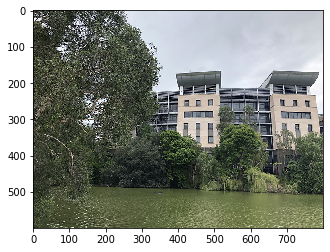

In [5]:
my_show(img1)

In [12]:
sift = cv2.xfeatures2d.SIFT_create()

In [13]:
def key_points(img, sift):
    kp = sift.detect(img)
    kp, des = sift.compute(img, kp)
    return kp, des


In [14]:
kp1, des1 = key_points(img1, sift)
print(des1.shape)

(3104, 128)


In [10]:
def show_key_points(img, kp):
    img_sift = cv2.drawKeypoints(img, kp, outImage=np.array([]),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(10,10),dpi=100)
    my_show(img_sift)

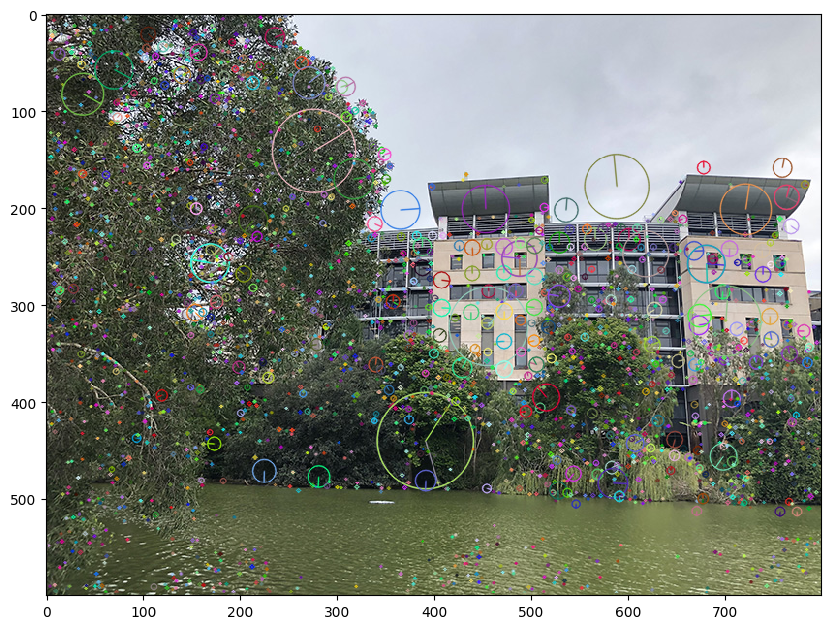

In [11]:
show_key_points(img1, kp1)

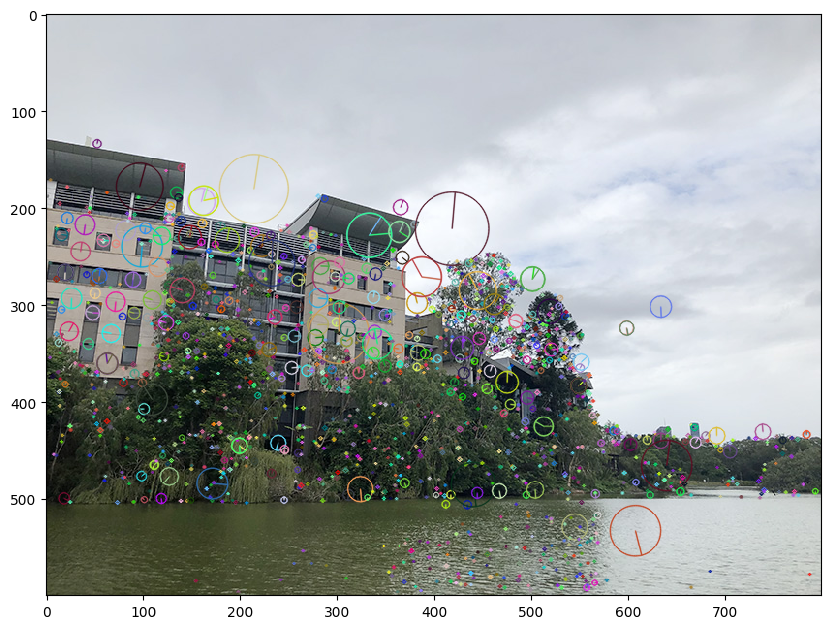

In [15]:
kp2, des2 = key_points(img2, sift)
show_key_points(img2,kp2)


In [21]:
def show_key_points(img, kp):
    img_sift = cv2.drawKeypoints(img, kp, outImage=np.array([]),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(10,10),dpi=100)
    my_show(img_sift)

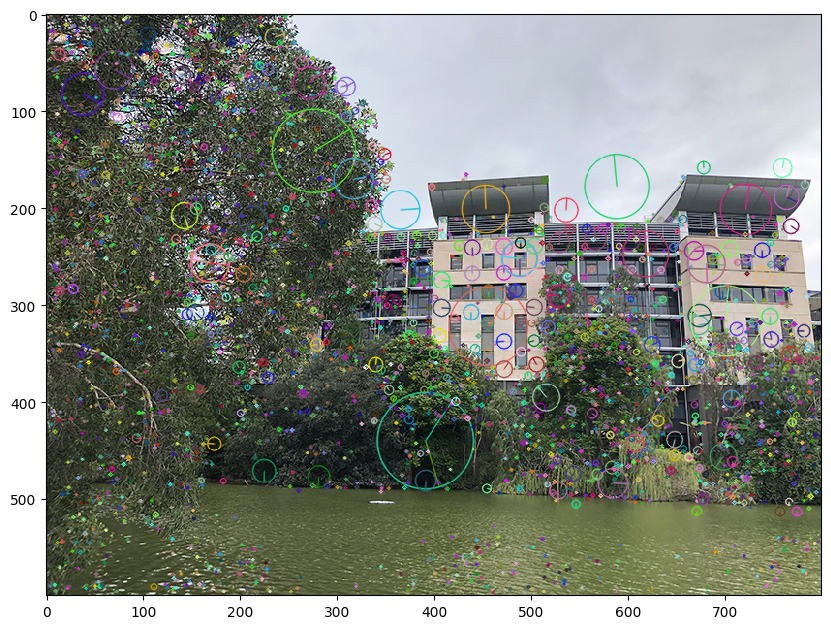

In [22]:
show_key_points(img1, kp1)

In [53]:
stitcher = cv2.createStitcher()

In [54]:
(status, stitched) = stitcher.stitch(images)

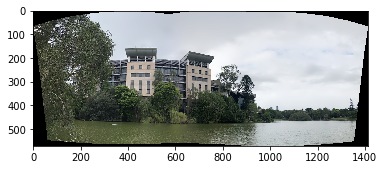

In [55]:
my_show(stitched)

In [56]:
# create a 10 pixel border surrounding the stitched image
stitched = cv2.copyMakeBorder(stitched, 10, 10, 10, 10, cv2.BORDER_CONSTANT, (0, 0, 0))

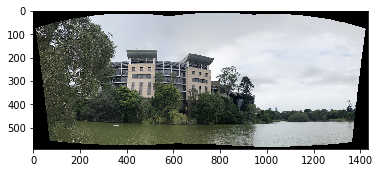

In [57]:
my_show(stitched)

In [58]:
# convert the stitched image to grayscale and threshold it
# such that all pixels greater than zero are set to 255
# (foreground) while all others remain 0 (background)
gray = cv2.cvtColor(stitched, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

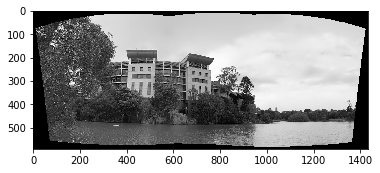

In [59]:
plt.imshow(gray,cmap='gray')

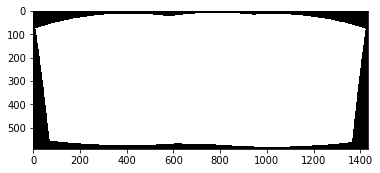

In [60]:
plt.imshow(thresh,cmap='gray')

In [61]:
# find all external contours in the threshold image then find
# the *largest* contour which will be the contour/outline of
# the stitched image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
c.shape

(696, 1, 2)

In [62]:
# allocate memory for the mask which will contain the
# rectangular bounding box of the stitched image region
mask = np.zeros(thresh.shape, dtype="uint8")
(x, y, w, h) = cv2.boundingRect(c)
cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)
mask.shape

(591, 1433)

In [63]:
# create two copies of the mask: one to serve as our actual
# minimum rectangular region and another to serve as a counter
# for how many pixels need to be removed to form the minimum
# rectangular region
minRect = mask.copy()
sub = mask.copy()

In [64]:
# keep looping until there are no non-zero pixels left in the
# subtracted image
while cv2.countNonZero(sub) > 0:
    # erode the minimum rectangular mask and then subtract
    # the thresholded image from the minimum rectangular mask
    # so we can count if there are any non-zero pixels left
    minRect = cv2.erode(minRect, None)
    sub = cv2.subtract(minRect, thresh)

In [65]:
# find contours in the minimum rectangular mask and then
# extract the bounding box (x, y)-coordinates
cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
(x, y, w, h) = cv2.boundingRect(c)

In [66]:
# use the bounding box coordinates to extract the our final
# stitched image
stitched = stitched[y:y + h, x:x + w]

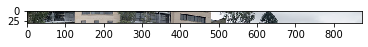

In [67]:
my_show(stitched)

V2

In [68]:
sift = cv2.xfeatures2d.SIFT_create()

In [69]:
def key_points(img, sift):
    kp = sift.detect(img)
    kp, des = sift.compute(img, kp)
    return kp, des

In [70]:
kp1, des1 = key_points(img1, sift)
kp2, des2 = key_points(img2, sift)

In [71]:
matcher = cv2.BFMatcher()
raw_matches = matcher.knnMatch(des1, des2, k=2)
raw_matches

In [73]:
ratio=0.85
min_match=10
smoothing_window_size=800

In [75]:
good_points = []
good_matches=[]

for m1, m2 in raw_matches:
    if m1.distance < ratio * m2.distance:
        good_points.append((m1.trainIdx, m1.queryIdx))
        good_matches.append([m1])
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
if len(good_points) > min_match:
    image1_kp = np.float32(
        [kp1[i].pt for (_, i) in good_points])
    image2_kp = np.float32(
        [kp2[i].pt for (i, _) in good_points])
    H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)

In [80]:
def create_mask(img1,img2,version):
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 +width_img2
    offset = int(smoothing_window_size / 2)
    barrier = img1.shape[1] - int(smoothing_window_size / 2)
    mask = np.zeros((height_panorama, width_panorama))
    if version== 'left_image':
        mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
        mask[:, :barrier - offset] = 1
    else:
        mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
        mask[:, barrier + offset:] = 1
    return cv2.merge([mask, mask, mask])

In [81]:
height_img1 = img1.shape[0]
width_img1 = img1.shape[1]
width_img2 = img2.shape[1]
height_panorama = height_img1
width_panorama = width_img1 +width_img2

panorama1 = np.zeros((height_panorama, width_panorama, 3))
mask1 = create_mask(img1,img2,version='left_image')
panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
panorama1 *= mask1
mask2 = create_mask(img1,img2,version='right_image')
panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama))*mask2
result=panorama1+panorama2

rows, cols = np.where(result[:, :, 0] != 0)
min_row, max_row = min(rows), max(rows) + 1
min_col, max_col = min(cols), max(cols) + 1
final_result = result[min_row:max_row, min_col:max_col, :]

In [85]:
final_result = np.array(final_result).astype("uint8")
final_result

array([[[ 63,  74,  72],
        [ 98, 109, 107],
        [126, 134, 134],
        ...,
        [232, 223, 219],
        [232, 223, 219],
        [232, 223, 219]],

       [[ 45,  56,  54],
        [ 20,  30,  30],
        [ 45,  54,  57],
        ...,
        [232, 223, 219],
        [232, 223, 219],
        [232, 223, 219]],

       [[ 72,  80,  80],
        [ 77,  86,  89],
        [ 39,  51,  55],
        ...,
        [232, 223, 219],
        [232, 223, 219],
        [232, 223, 219]],

       ...,

       [[ 32,  46,  40],
        [ 36,  54,  47],
        [ 52,  73,  65],
        ...,
        [213, 213, 208],
        [213, 212, 207],
        [213, 212, 208]],

       [[ 29,  50,  42],
        [ 39,  60,  52],
        [ 48,  69,  61],
        ...,
        [212, 212, 206],
        [211, 211, 205],
        [210, 210, 204]],

       [[ 32,  57,  47],
        [ 33,  58,  48],
        [ 31,  52,  43],
        ...,
        [213, 213, 207],
        [212, 212, 206],
        [211, 211, 205]]

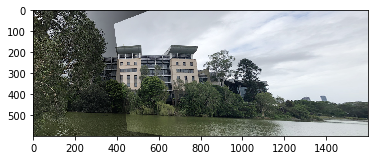

In [86]:
my_show(final_result)